## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

In [1]:
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
sns.__version__

'0.11.0'

# Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../data/datasets/crisdb/`

In [3]:
hr_filenames = glob.glob(os.path.join('..','data','datasets', 'crisdb', '*.npz'))

In [5]:
len(hr_filenames)

1537

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [6]:
metadata_filename = os.path.join('..', 'data', 'datasets', 'crisdb', 'metadata.csv')

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(f)

In [7]:
metadata.shape

(1543, 3)

In [8]:
metadata.head(10)

,subject,age,sex
0,e198a,20-24,Male
1,e198b,20-24,Male
2,e028b,30-34,Male
3,e028a,30-34,Male
4,e061b,30-34,Male
5,e061a,30-34,Male
6,e265b,35-39,Male
7,e033b,35-39,Male
8,e265a,35-39,Male
9,e033a,35-39,Male


#### EDA

In [9]:
metadata.sex.value_counts()

Male      1266
Female     277
Name: sex, dtype: int64

In [10]:
metadata.age.value_counts()

60-64    313
65-69    291
55-59    261
70-74    196
50-54    164
45-49    124
75-79     98
40-44     62
35-39     28
30-34      4
20-24      2
Name: age, dtype: int64

In [11]:
metadata[metadata['sex']=='Female'].age.value_counts()

60-64    67
65-69    61
55-59    46
70-74    39
75-79    19
50-54    18
45-49    15
40-44     8
35-39     4
Name: age, dtype: int64

#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [12]:
hr_file1 = np.load(hr_filenames[0])

In [13]:
hr_file1.files

['hr']

In [14]:
hr_data = hr_file1['hr']

In [15]:
hr_data.shape

(86143,)

In [16]:
np.percentile(hr_data, 5)

65.08474576271186

In [17]:
np.min(hr_data[hr_data == np.percentile(hr_data, 5)])

65.08474576271186

In [18]:
name1 = os.path.split(hr_filenames[0])[1][0:5]
name1

'e001a'

In [19]:
metadata[metadata['subject']==name1]['age'].values[0]

'60-64'

In [20]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    subject = os.path.split(filename)[1][0:5]

    # Find the age group for this subject in metadata.
    age_group = metadata[metadata['subject']==subject]['age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata[metadata['subject']==subject]['sex'].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [21]:
df.head(20)

,age_group,sex,rhr
0,60-64,Male,65.084746
1,60-64,Male,69.818182
2,65-69,Male,77.591753
3,65-69,Male,72.024615
4,55-59,Male,54.111052
5,55-59,Male,57.047334
6,45-49,Male,81.702128
7,45-49,Male,69.818182
8,70-74,Male,47.116564
9,70-74,Male,40.580956


#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

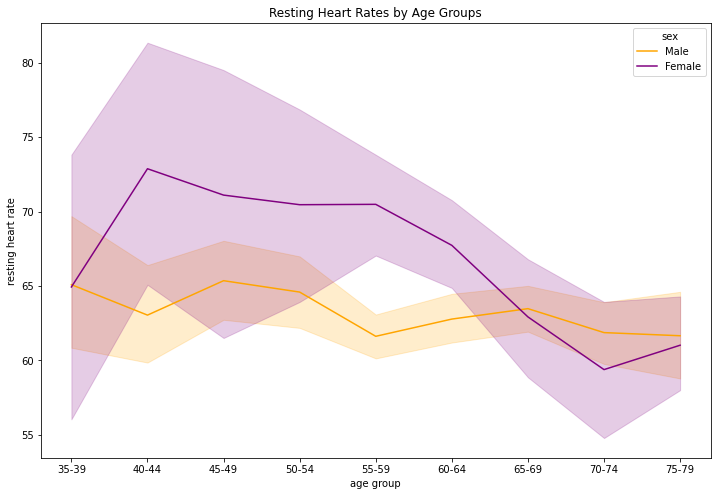

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df, palette={'Male':'orange', 'Female':'purple'})
plt.title('Resting Heart Rates by Age Groups')
plt.xlabel('age group')
plt.ylabel('resting heart rate')
_ = plt.xticks(np.arange(len(labels)), labels)
plt.savefig('out/Resting_HR_by_Age_Groups')

### Clinical Conclusion
Answer the following prompts to draw a conclusion about the data.
> 1. For women, we see .... 
> 2. For men, we see ... 
> 3. In comparison to men, women's heart rate is .... 
> 4. What are some possible reasons for what we see in our data?
> 5. What else can we do or go and find to figure out what is really happening? How would that improve the results?
> 6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?

Your write-up will go here...

1.  For women, we see from 95% Confidence Intervals that the BPM range is 55 - 85 BPM.  We see that the heart rate changes with age, with heart rates on-average at the highest peak in the age range of 40-44 years old.

2.  For men, we see from 95% Confidence Intervals that the BPM range is 60 - 70 BPM.  We also see that the heart rate changes with age, with heart rates on-average at the highest peak in the age range of 45-49 years old.

3.  We see the following differences between men's and women's heart rates:  
-In comparison to men, women's heart rates show a wider range within each age group.  For the 35-39, 40-44, and 45-49 age groups, the range of women's heart rates in the 95% CI is nearly 20BPM.  On the other hand, the range of men's heart rates in the 95%CI is less than 10BPM.  
-The mean of women's heart rates show more variability across age groups than men.  The range of the mean of women's heart rates is 60 BPM - 70 BPM.  For men, the rate of their mean heart rates is 62.5 BPM - 65 BPM.  

4.  The following are possible reasons for the variability in women's heart rates data:  
-The amount of data for men and women are not balanced in our dataset.  There are 1,266 Males and 277 Female in the dataset.  Obtaining more data from Females will reduce variability and standard deviation, thus the 95% CI as well.  
-The amount of data in each age group also affects the variability.  For women, the age group 35-39 only has 4 data points, the 40-44 age group only has 8 data points.  These groups have ranges of approximately 20 BPM in the 95% CI.  In comparison, for women in the age group 60-64 there are 67 data points.  This group has a smaller range of approximately 5 BPM in the 95% CI.  

5.   The data in the project comes from CAST.  The data is 24 hours of ECG heart rate data from people who have had a myocardial infarction (MI) within the past two years.  
To prove the generalizability of these results, we need data from the general population that has not had a myocardial infarction.  
We can look for more heart rate data from other studies and papers.  
We may also conduct our own trials to collect heart rate information for men and women.

6.  Using the CAST data, we see the overall trend that human resting heart rates decrease from middle age until old age.  We did not have data to show that heart rates increase from young ages to middle age.
